In [1]:
import torch
import torchvision
from torchvision.transforms import Normalize,ToTensor,Compose
from torchvision.datasets import MNIST

mnist = MNIST(root='data',train=True,transform = Compose([ToTensor(),Normalize(mean=(0.5,),std=(0.5,))]))

In [2]:
img,label = mnist[0]
print('Label:',label)
print(img[:,10:15,10:15])
torch.min(img),torch.max(img)

Label: 5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

In [3]:
def denorm(x):
    out = (x+1)/2
    return out.clamp(0,1)

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

Label: 5


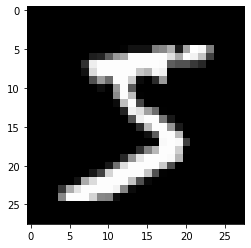

In [5]:
img_norm = denorm(img)
plt.imshow(img_norm[0],cmap='gray')
print('Label:',label)

In [6]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist,batch_size,shuffle=True)

First Batch
torch.Size([100, 1, 28, 28])
tensor([0, 6, 2, 0, 3, 1, 5, 8, 3, 9, 0, 8, 8, 4, 6, 6, 0, 7, 3, 5, 4, 4, 9, 0,
        6, 8, 2, 9, 0, 1, 3, 7, 1, 1, 3, 7, 2, 3, 7, 7, 3, 4, 5, 9, 1, 4, 9, 8,
        4, 4, 1, 9, 3, 5, 4, 6, 2, 4, 6, 2, 0, 1, 6, 8, 6, 8, 9, 4, 5, 2, 4, 7,
        3, 8, 6, 8, 7, 8, 5, 1, 3, 3, 2, 9, 5, 9, 5, 2, 8, 3, 8, 4, 5, 1, 7, 7,
        6, 3, 4, 0])


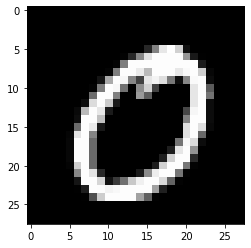

In [7]:
for img_batch,label_batch in data_loader:
    print('First Batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0],cmap='gray')
    print(label_batch)
    break

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
image_size = 784
hidden_size = 256

In [10]:
import torch.nn as nn

D = nn.Sequential(nn.Linear(image_size,hidden_size),
                  nn.LeakyReLU(0.2),
                  nn.Linear(hidden_size,hidden_size),
                  nn.LeakyReLU(0.2),
                  nn.Linear(hidden_size,1),
                  nn.Sigmoid())

In [11]:
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

In [12]:
latent_size = 64

In [13]:
G = nn.Sequential(nn.Linear(latent_size, hidden_size),
                  nn.ReLU(),
                  nn.Linear(hidden_size, hidden_size),
                  nn.ReLU(),
                  nn.Linear(hidden_size, image_size),
                  nn.Tanh())

In [14]:
y = G(torch.randn(2,latent_size))
gen_imgs = denorm(y.reshape((-1,28,28)).detach())

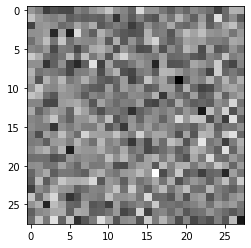

In [15]:
plt.imshow(gen_imgs[0],cmap='gray')

In [16]:
G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

In [17]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [18]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

In [19]:
g_optimizer = torch.optim.Adam(G.parameters(),lr=0.0002)

In [20]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [1]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

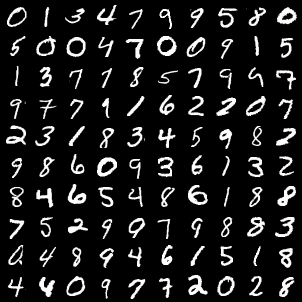

In [22]:
from IPython.display import Image
from torchvision.utils import save_image

for images,_ in data_loader:
    images = images.reshape(-1,1,28,28)
    save_image(denorm(images),os.path.join(sample_dir,'real_images.png'),nrow=10)
    break
    
Image(os.path.join(sample_dir,'real_images.png'))

Saving fake_images-0000.png


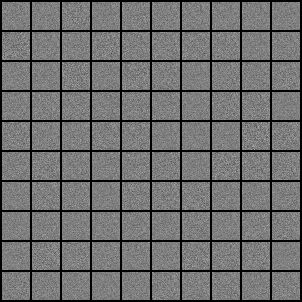

In [23]:
sample_vectors = torch.randn(batch_size,latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(-1,1,28,28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving',fake_fname)
    save_image(denorm(fake_images),os.path.join(sample_dir, fake_fname), nrow=10)
    
save_fake_images(0)
Image(os.path.join(sample_dir,'fake_images-0000.png'))

In [24]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0729, g_loss: 4.1801, D(x): 0.98, D(G(z)): 0.05
Epoch [0/300], Step [400/600], d_loss: 0.0788, g_loss: 5.8597, D(x): 0.97, D(G(z)): 0.03
Epoch [0/300], Step [600/600], d_loss: 0.0436, g_loss: 4.9772, D(x): 0.98, D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0189, g_loss: 5.6268, D(x): 0.99, D(G(z)): 0.01
Epoch [1/300], Step [400/600], d_loss: 0.1358, g_loss: 5.2617, D(x): 0.94, D(G(z)): 0.04
Epoch [1/300], Step [600/600], d_loss: 0.0850, g_loss: 5.0209, D(x): 0.99, D(G(z)): 0.06
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.1128, g_loss: 4.5876, D(x): 0.97, D(G(z)): 0.07
Epoch [2/300], Step [400/600], d_loss: 0.8092, g_loss: 3.3092, D(x): 0.78, D(G(z)): 0.26
Epoch [2/300], Step [600/600], d_loss: 0.6358, g_loss: 3.3526, D(x): 0.86, D(G(z)): 0.25
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.2374, g_loss: 2.6557, D(x): 0.95, D(G(z)): 0.15
Epoch [3/300], Step [400/6

Epoch [27/300], Step [600/600], d_loss: 0.4889, g_loss: 4.3542, D(x): 0.86, D(G(z)): 0.08
Saving fake_images-0028.png
Epoch [28/300], Step [200/600], d_loss: 0.2657, g_loss: 4.2765, D(x): 0.91, D(G(z)): 0.08
Epoch [28/300], Step [400/600], d_loss: 0.5641, g_loss: 3.4697, D(x): 0.79, D(G(z)): 0.06
Epoch [28/300], Step [600/600], d_loss: 0.2605, g_loss: 4.3513, D(x): 0.89, D(G(z)): 0.06
Saving fake_images-0029.png
Epoch [29/300], Step [200/600], d_loss: 0.4085, g_loss: 5.0898, D(x): 0.92, D(G(z)): 0.16
Epoch [29/300], Step [400/600], d_loss: 0.4301, g_loss: 3.5007, D(x): 0.87, D(G(z)): 0.09
Epoch [29/300], Step [600/600], d_loss: 0.4711, g_loss: 3.2122, D(x): 0.83, D(G(z)): 0.07
Saving fake_images-0030.png
Epoch [30/300], Step [200/600], d_loss: 0.3198, g_loss: 3.9358, D(x): 0.90, D(G(z)): 0.09
Epoch [30/300], Step [400/600], d_loss: 0.4012, g_loss: 3.1651, D(x): 0.86, D(G(z)): 0.06
Epoch [30/300], Step [600/600], d_loss: 0.3607, g_loss: 4.0392, D(x): 0.88, D(G(z)): 0.09
Saving fake_imag

Epoch [55/300], Step [400/600], d_loss: 0.4954, g_loss: 2.8095, D(x): 0.84, D(G(z)): 0.16
Epoch [55/300], Step [600/600], d_loss: 0.4388, g_loss: 2.7303, D(x): 0.92, D(G(z)): 0.24
Saving fake_images-0056.png
Epoch [56/300], Step [200/600], d_loss: 0.5716, g_loss: 3.0242, D(x): 0.85, D(G(z)): 0.21
Epoch [56/300], Step [400/600], d_loss: 0.6757, g_loss: 3.1373, D(x): 0.73, D(G(z)): 0.11
Epoch [56/300], Step [600/600], d_loss: 0.7736, g_loss: 1.5660, D(x): 0.84, D(G(z)): 0.30
Saving fake_images-0057.png
Epoch [57/300], Step [200/600], d_loss: 0.6300, g_loss: 3.0107, D(x): 0.81, D(G(z)): 0.20
Epoch [57/300], Step [400/600], d_loss: 0.4591, g_loss: 3.2976, D(x): 0.83, D(G(z)): 0.14
Epoch [57/300], Step [600/600], d_loss: 0.4313, g_loss: 1.7714, D(x): 0.84, D(G(z)): 0.16
Saving fake_images-0058.png
Epoch [58/300], Step [200/600], d_loss: 0.6267, g_loss: 1.8322, D(x): 0.75, D(G(z)): 0.16
Epoch [58/300], Step [400/600], d_loss: 0.4893, g_loss: 2.4848, D(x): 0.87, D(G(z)): 0.19
Epoch [58/300], 

Epoch [83/300], Step [200/600], d_loss: 0.5276, g_loss: 2.5102, D(x): 0.83, D(G(z)): 0.17
Epoch [83/300], Step [400/600], d_loss: 0.5348, g_loss: 2.4010, D(x): 0.77, D(G(z)): 0.16
Epoch [83/300], Step [600/600], d_loss: 0.9901, g_loss: 1.8020, D(x): 0.69, D(G(z)): 0.23
Saving fake_images-0084.png
Epoch [84/300], Step [200/600], d_loss: 0.6622, g_loss: 2.0665, D(x): 0.76, D(G(z)): 0.22
Epoch [84/300], Step [400/600], d_loss: 0.6232, g_loss: 1.9608, D(x): 0.82, D(G(z)): 0.25
Epoch [84/300], Step [600/600], d_loss: 0.7019, g_loss: 2.4602, D(x): 0.80, D(G(z)): 0.23
Saving fake_images-0085.png
Epoch [85/300], Step [200/600], d_loss: 0.6023, g_loss: 2.3671, D(x): 0.81, D(G(z)): 0.21
Epoch [85/300], Step [400/600], d_loss: 0.6113, g_loss: 2.5012, D(x): 0.80, D(G(z)): 0.22
Epoch [85/300], Step [600/600], d_loss: 0.8131, g_loss: 2.8269, D(x): 0.67, D(G(z)): 0.11
Saving fake_images-0086.png
Epoch [86/300], Step [200/600], d_loss: 0.6662, g_loss: 1.9569, D(x): 0.87, D(G(z)): 0.32
Epoch [86/300], 

Epoch [110/300], Step [600/600], d_loss: 0.8215, g_loss: 1.7512, D(x): 0.81, D(G(z)): 0.34
Saving fake_images-0111.png
Epoch [111/300], Step [200/600], d_loss: 0.8328, g_loss: 1.9521, D(x): 0.77, D(G(z)): 0.32
Epoch [111/300], Step [400/600], d_loss: 0.8711, g_loss: 1.6975, D(x): 0.80, D(G(z)): 0.33
Epoch [111/300], Step [600/600], d_loss: 0.6435, g_loss: 1.8418, D(x): 0.79, D(G(z)): 0.22
Saving fake_images-0112.png
Epoch [112/300], Step [200/600], d_loss: 0.8232, g_loss: 1.7644, D(x): 0.81, D(G(z)): 0.35
Epoch [112/300], Step [400/600], d_loss: 0.8563, g_loss: 1.6241, D(x): 0.75, D(G(z)): 0.29
Epoch [112/300], Step [600/600], d_loss: 0.8711, g_loss: 1.6628, D(x): 0.74, D(G(z)): 0.31
Saving fake_images-0113.png
Epoch [113/300], Step [200/600], d_loss: 0.7792, g_loss: 1.6261, D(x): 0.75, D(G(z)): 0.26
Epoch [113/300], Step [400/600], d_loss: 0.7730, g_loss: 1.8014, D(x): 0.73, D(G(z)): 0.26
Epoch [113/300], Step [600/600], d_loss: 0.6578, g_loss: 1.9006, D(x): 0.75, D(G(z)): 0.21
Saving

Epoch [138/300], Step [200/600], d_loss: 0.8756, g_loss: 1.4259, D(x): 0.73, D(G(z)): 0.32
Epoch [138/300], Step [400/600], d_loss: 0.8907, g_loss: 1.4954, D(x): 0.70, D(G(z)): 0.28
Epoch [138/300], Step [600/600], d_loss: 0.8860, g_loss: 1.8211, D(x): 0.71, D(G(z)): 0.27
Saving fake_images-0139.png
Epoch [139/300], Step [200/600], d_loss: 1.0286, g_loss: 2.1917, D(x): 0.58, D(G(z)): 0.18
Epoch [139/300], Step [400/600], d_loss: 1.0492, g_loss: 1.3663, D(x): 0.60, D(G(z)): 0.27
Epoch [139/300], Step [600/600], d_loss: 0.9187, g_loss: 1.7311, D(x): 0.71, D(G(z)): 0.30
Saving fake_images-0140.png
Epoch [140/300], Step [200/600], d_loss: 0.8408, g_loss: 1.8363, D(x): 0.70, D(G(z)): 0.28
Epoch [140/300], Step [400/600], d_loss: 0.7194, g_loss: 1.8323, D(x): 0.75, D(G(z)): 0.25
Epoch [140/300], Step [600/600], d_loss: 1.1211, g_loss: 1.6486, D(x): 0.65, D(G(z)): 0.36
Saving fake_images-0141.png
Epoch [141/300], Step [200/600], d_loss: 0.8909, g_loss: 1.4450, D(x): 0.70, D(G(z)): 0.27
Epoch 

Epoch [165/300], Step [400/600], d_loss: 0.9132, g_loss: 1.7629, D(x): 0.66, D(G(z)): 0.25
Epoch [165/300], Step [600/600], d_loss: 0.9040, g_loss: 1.6589, D(x): 0.65, D(G(z)): 0.25
Saving fake_images-0166.png
Epoch [166/300], Step [200/600], d_loss: 0.8966, g_loss: 1.5495, D(x): 0.72, D(G(z)): 0.30
Epoch [166/300], Step [400/600], d_loss: 1.0201, g_loss: 1.4422, D(x): 0.75, D(G(z)): 0.38
Epoch [166/300], Step [600/600], d_loss: 0.8989, g_loss: 1.7837, D(x): 0.76, D(G(z)): 0.37
Saving fake_images-0167.png
Epoch [167/300], Step [200/600], d_loss: 0.9636, g_loss: 1.5259, D(x): 0.79, D(G(z)): 0.39
Epoch [167/300], Step [400/600], d_loss: 0.9876, g_loss: 1.4473, D(x): 0.76, D(G(z)): 0.39
Epoch [167/300], Step [600/600], d_loss: 0.8053, g_loss: 1.5573, D(x): 0.70, D(G(z)): 0.25
Saving fake_images-0168.png
Epoch [168/300], Step [200/600], d_loss: 0.8781, g_loss: 1.6931, D(x): 0.69, D(G(z)): 0.29
Epoch [168/300], Step [400/600], d_loss: 0.9595, g_loss: 1.5436, D(x): 0.73, D(G(z)): 0.36
Epoch 

Epoch [192/300], Step [600/600], d_loss: 0.9452, g_loss: 1.2306, D(x): 0.70, D(G(z)): 0.33
Saving fake_images-0193.png
Epoch [193/300], Step [200/600], d_loss: 0.8638, g_loss: 1.6857, D(x): 0.68, D(G(z)): 0.23
Epoch [193/300], Step [400/600], d_loss: 0.9899, g_loss: 1.4901, D(x): 0.64, D(G(z)): 0.26
Epoch [193/300], Step [600/600], d_loss: 0.9103, g_loss: 1.8176, D(x): 0.60, D(G(z)): 0.21
Saving fake_images-0194.png
Epoch [194/300], Step [200/600], d_loss: 1.0087, g_loss: 1.3503, D(x): 0.69, D(G(z)): 0.33
Epoch [194/300], Step [400/600], d_loss: 0.9559, g_loss: 1.3574, D(x): 0.74, D(G(z)): 0.37
Epoch [194/300], Step [600/600], d_loss: 1.0371, g_loss: 1.3457, D(x): 0.64, D(G(z)): 0.31
Saving fake_images-0195.png
Epoch [195/300], Step [200/600], d_loss: 0.9422, g_loss: 1.6571, D(x): 0.67, D(G(z)): 0.29
Epoch [195/300], Step [400/600], d_loss: 1.2380, g_loss: 1.3359, D(x): 0.68, D(G(z)): 0.44
Epoch [195/300], Step [600/600], d_loss: 0.8597, g_loss: 1.2519, D(x): 0.74, D(G(z)): 0.33
Saving

Epoch [220/300], Step [200/600], d_loss: 0.8610, g_loss: 1.7102, D(x): 0.66, D(G(z)): 0.23
Epoch [220/300], Step [400/600], d_loss: 0.9588, g_loss: 1.4271, D(x): 0.65, D(G(z)): 0.27
Epoch [220/300], Step [600/600], d_loss: 1.0509, g_loss: 1.4412, D(x): 0.67, D(G(z)): 0.32
Saving fake_images-0221.png
Epoch [221/300], Step [200/600], d_loss: 0.9428, g_loss: 1.7804, D(x): 0.68, D(G(z)): 0.31
Epoch [221/300], Step [400/600], d_loss: 1.0015, g_loss: 1.1659, D(x): 0.68, D(G(z)): 0.31
Epoch [221/300], Step [600/600], d_loss: 0.9780, g_loss: 1.4087, D(x): 0.63, D(G(z)): 0.26
Saving fake_images-0222.png
Epoch [222/300], Step [200/600], d_loss: 0.8064, g_loss: 1.4906, D(x): 0.73, D(G(z)): 0.28
Epoch [222/300], Step [400/600], d_loss: 0.8207, g_loss: 1.1932, D(x): 0.75, D(G(z)): 0.33
Epoch [222/300], Step [600/600], d_loss: 0.7790, g_loss: 1.5480, D(x): 0.78, D(G(z)): 0.32
Saving fake_images-0223.png
Epoch [223/300], Step [200/600], d_loss: 0.8027, g_loss: 1.4444, D(x): 0.69, D(G(z)): 0.24
Epoch 

Epoch [247/300], Step [400/600], d_loss: 1.0682, g_loss: 1.6184, D(x): 0.66, D(G(z)): 0.33
Epoch [247/300], Step [600/600], d_loss: 0.9401, g_loss: 1.1765, D(x): 0.71, D(G(z)): 0.32
Saving fake_images-0248.png
Epoch [248/300], Step [200/600], d_loss: 0.9648, g_loss: 1.8524, D(x): 0.65, D(G(z)): 0.31
Epoch [248/300], Step [400/600], d_loss: 0.9014, g_loss: 1.2430, D(x): 0.71, D(G(z)): 0.32
Epoch [248/300], Step [600/600], d_loss: 1.0172, g_loss: 1.4094, D(x): 0.70, D(G(z)): 0.35
Saving fake_images-0249.png
Epoch [249/300], Step [200/600], d_loss: 0.9111, g_loss: 1.3232, D(x): 0.68, D(G(z)): 0.31
Epoch [249/300], Step [400/600], d_loss: 0.9599, g_loss: 1.5451, D(x): 0.73, D(G(z)): 0.36
Epoch [249/300], Step [600/600], d_loss: 1.0051, g_loss: 1.1955, D(x): 0.72, D(G(z)): 0.36
Saving fake_images-0250.png
Epoch [250/300], Step [200/600], d_loss: 1.0275, g_loss: 1.4208, D(x): 0.59, D(G(z)): 0.24
Epoch [250/300], Step [400/600], d_loss: 0.8906, g_loss: 0.9712, D(x): 0.74, D(G(z)): 0.36
Epoch 

Epoch [274/300], Step [600/600], d_loss: 1.0212, g_loss: 1.9442, D(x): 0.60, D(G(z)): 0.24
Saving fake_images-0275.png
Epoch [275/300], Step [200/600], d_loss: 0.8384, g_loss: 1.3959, D(x): 0.70, D(G(z)): 0.29
Epoch [275/300], Step [400/600], d_loss: 1.0266, g_loss: 1.3462, D(x): 0.72, D(G(z)): 0.38
Epoch [275/300], Step [600/600], d_loss: 0.9552, g_loss: 1.3355, D(x): 0.68, D(G(z)): 0.30
Saving fake_images-0276.png
Epoch [276/300], Step [200/600], d_loss: 0.9193, g_loss: 1.3314, D(x): 0.68, D(G(z)): 0.30
Epoch [276/300], Step [400/600], d_loss: 0.8302, g_loss: 1.5346, D(x): 0.66, D(G(z)): 0.22
Epoch [276/300], Step [600/600], d_loss: 0.9994, g_loss: 1.1780, D(x): 0.71, D(G(z)): 0.40
Saving fake_images-0277.png
Epoch [277/300], Step [200/600], d_loss: 0.8619, g_loss: 1.5565, D(x): 0.65, D(G(z)): 0.21
Epoch [277/300], Step [400/600], d_loss: 0.8513, g_loss: 1.2545, D(x): 0.73, D(G(z)): 0.33
Epoch [277/300], Step [600/600], d_loss: 0.8420, g_loss: 1.3844, D(x): 0.71, D(G(z)): 0.30
Saving

In [25]:
# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

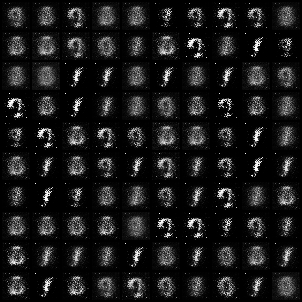

In [26]:
Image('./samples/fake_images-0010.png')

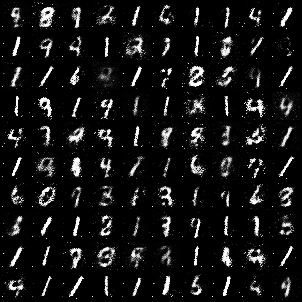

In [27]:
Image('./samples/fake_images-0050.png')

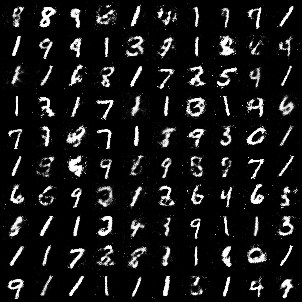

In [28]:
Image('./samples/fake_images-0100.png')

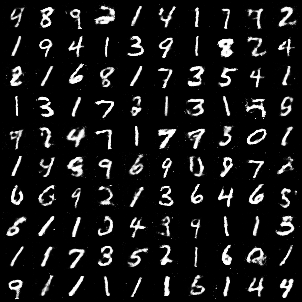

In [29]:
Image('./samples/fake_images-0300.png')

In [2]:
import os
os.system("ffmpeg -r 8 -i ./samples/fake_images-%04d.png -vcodec mpeg4 -y movie.mp4")

0

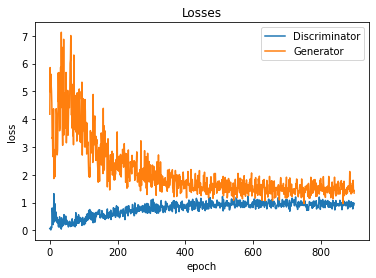

In [33]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

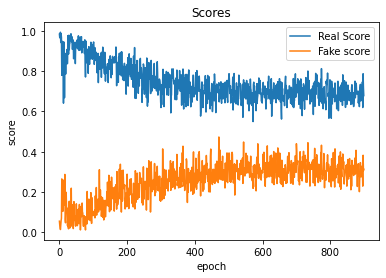

In [34]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');